## RPA

In [13]:
import pandas as pd
from utils.model import Spice_Encoder
import torch
from data_files.dataset import CQT_Dataset
from torch.utils.data import DataLoader
from data_files.dataloader import MedleyDBLoader, MDBMelodySynthLoader, MIR1KLoader

In [14]:
def output2hz(pitch_output):
  # Constants taken from https://tfhub.dev/google/spice/2
  PT_OFFSET = 25.58
  PT_SLOPE = 63.07
  FMIN = 10.0    #why is it 10, not 110?
  BINS_PER_OCTAVE = 12.0  
  cqt_bin = pitch_output * PT_SLOPE + PT_OFFSET;
  return FMIN * 2.0 ** (1.0 * cqt_bin / BINS_PER_OCTAVE)

In [43]:
import torch
from utils.model import Spice_model

model = Spice_model([1, 64, 128, 256, 512, 512, 512], [512, 512, 512, 256, 128, 64, 1], [True, True, True, True, True, True])
checkpoint = torch.load('./rev_1k_checkpoints/checkpoint_mir_643.ckp', 'cuda' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [2]:
from data_files.dataloader import MedleyDBLoader, MDBMelodySynthLoader, MIR1KLoader

In [52]:
pitch_h,conf_h,x_hat = model(torch.randn((10,128)))

In [15]:
fs = 16000
mir1k = MIR1KLoader(fs)
my_id = 'abjones_1_03'
# datasets/MIR-1K-Stem/Wavfile/abjones_1_03.wav
x_audio, f0 = mir1k.load_data(my_id)
print(f0.shape, x_audio.shape)

(3, 355) (1, 114177)


In [16]:
x_audio = x_audio.squeeze(axis=0)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

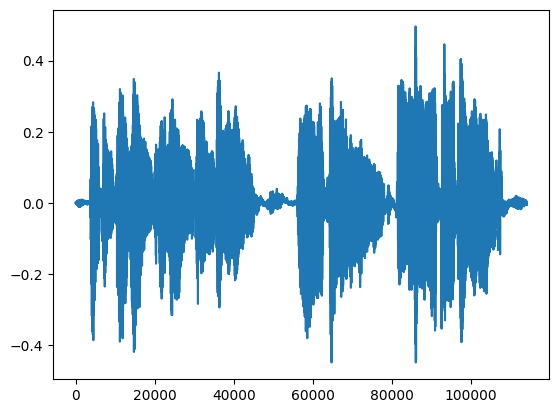

In [17]:
audio_samples = x_audio
from matplotlib import pyplot as plt
_ = plt.plot(audio_samples)

f0[1]

In [18]:
def Cqt_song(songs, f0_list):
    fs = 16000
    hop_len = 512
    # Convert to CQT array and concat
    Cqtt = np.zeros((1, 190))
    voicing_interp = np.zeros(1)
    F0_interp = np.zeros(1)
    for s, f in zip(songs, f0_list):
        C = np.abs(librosa.cqt(s, sr=fs, hop_length=hop_len, 
                    #window=librosa.filters.get_window('hann', Nx=1024, fftbins=False), 
                    fmin= librosa.note_to_hz('C1'),
                    n_bins=190, bins_per_octave=24))
        #print("CQT shape: ", C.shape)
        Cqtt = np.vstack((Cqtt, C.T))
        # interpolate f0 for labels 
        interpolator = scipy.interpolate.interp1d(x=f[0], y=f[2], axis=0, fill_value = 'extrapolate')
        interp_time = np.arange(0, C.shape[1], 1)*hop_len/fs
        f0_new = interpolator(interp_time)
        F0_interp = np.concatenate((F0_interp, f0_new))
        
        # interpolate voicing for labels 
        interpolator_voice = scipy.interpolate.interp1d(x=f[0], y=f[1], axis=0, fill_value = 'extrapolate')
        uv_new = interpolator_voice(interp_time)
        voicing_interp = np.concatenate((voicing_interp, uv_new))
        #print("F0 interpolated shape: ", f0_new)data_pd = pd.DataFrame(data=data_np) 
    #print("CQT & F0 Shape: ", Cqtt.shape, F0_interp.shape)
    return interp_time, Cqtt, F0_interp, voicing_interp

def Cqt_loader_frame(cqt_full):
    # return for each Cqt frame
    k_min, k_max, F_bins = 0, 8, 128
    k_1, k_2 = np.random.randint(k_min, k_max), np.random.randint(k_min, k_max)
    # return abs differrence, and two cqt slices of 128 length
    return np.abs(k_1 - k_2), cqt_full[k_1: k_1 + F_bins], cqt_full[k_2: k_2 + F_bins]

def Cqt_loader(cqt):
    s1_list = np.zeros(128)
    s2_list = np.zeros(128)
    diff_list = np.zeros(1)
    for i in range(len(cqt)):
        diff, s1, s2 = Cqt_loader_frame(cqt[i, :].squeeze())
        s1_list = np.vstack((s1_list, s1))
        s2_list = np.vstack((s2_list, s2))
        diff_list = np.vstack((diff_list, diff))
    
    return s1_list[1:], s2_list[1:], diff_list[1:]

In [29]:
import numpy as np
import librosa
import scipy
t,x,y, vu  = Cqt_song([audio_samples], [f0])
print(f'Cqt Shape: {x.shape}, F0 Interpolated Shape: {y.shape}')
s1, s2, diff = Cqt_loader(x)
print(f'Slice shape: {s1.shape}, Difference shape:{diff.shape}')
print(t.shape,y.shape)
# def step_func(n, threshold=0.5):
#     if n < threshold:
#         return 0.
#     if n >= threshold:
#         return 1.
# applyall = np.vectorize(step_func)
# res = applyall(vu)

# print("{}\n{}".format(vu,res))  # This will output 1.0

Cqt Shape: (225, 190), F0 Interpolated Shape: (225,)
Slice shape: (225, 128), Difference shape:(225, 1)
(224,) (225,)


In [60]:
y_hat = np.apply_along_axis(output2hz, 0, pitch_h.detach().numpy())
y_hat_cent = np.apply_along_axis(mir_eval.melody.hz2cents, 0, y_hat)
y_hat_voice = np.random.randint(2, size=y_hat.shape)
y = np.random.uniform(low=40, high=65, size=(10,1)) #extrapolate back to time
y_cent = np.apply_along_axis(mir_eval.melody.hz2cents, 0, y)
y_voice = np.random.randint(2, size=y.shape)
raw_pitch_accuracy = mir_eval.melody.raw_pitch_accuracy(y_voice, y_cent, y_hat_voice, y_hat_cent)
raw_pitch_accuracy

0.0

In [28]:
aa = np.array([111, 222,222,222,333])
bb = np.array([1,0,1,1,0])
aa[np.nonzero(aa*bb)]

array([111, 222, 222])

In [54]:
import mir_eval 
# raw_pitch_accuracy = mir_eval.melody.raw_pitch_accuracy(y, y_hat)

def raw_pitch_accuracy(ground_truth, pred):
    pitch_difference = np.abs(ground_truth - pred)
    half_semitone_threshold = ground_truth*2 ** (1/24) - ground_truth

    error_arr = np.subtract(pitch_difference, half_semitone_threshold)
    count_error = (error_arr > 0.0).sum()
    print(error_arr)
    percentage = (count_error / len(ground_truth)) * 100
    return percentage


In [55]:
raw_pitch_accuracy(y,y_hat)

[[15.1846428 ]
 [16.97339592]
 [26.01562903]
 [29.50201205]
 [27.44755152]
 [13.49949293]
 [25.61517218]
 [11.4925144 ]
 [24.66010954]
 [27.61804359]]


100.0

## Calibration

In [22]:
import math
import random
import numpy as np
from IPython.display import Audio
def pick_semitone_freq(low, high):
    semitone_ratio = 2 ** (1/12)
    semitone_freq_list = []
    
    current_freq = low
    while current_freq <= high:
        semitone_freq_list.append(current_freq)
        current_freq *= semitone_ratio
    
    return random.choice(semitone_freq_list)

# pick_semitone_freq(110, 440)

def generate_harmonic_wave(fundamental_freq, sampling_rate=16000, N=11, H=512):
    amplitude_f0 = np.random.normal(0, 1)
    t = np.linspace(0, (N*H) / sampling_rate, (N*H), endpoint=False)
    fundamental_signal = amplitude_f0*np.sin(2 * np.pi * fundamental_freq * t)
    harmonic_signal = fundamental_signal.copy()
    

    for i in range(2, 4):  
        frequency = fundamental_freq * i
        random_phase = random.uniform(0, 2 * math.pi)
        harmonic_signal += random.uniform(0, 1) * np.sin(2 * np.pi * frequency * t+random_phase)

    return harmonic_signal

In [23]:
class Generator():
    def __init__(self,M,low=110,high=440):
        self.M = M
        self.low = low
        self.high = high
        
    def generate(self):
        samples = []
        labels = []
        for i in range(self.M):
            f0 = pick_semitone_freq(self.low,self.high)
            wave = generate_harmonic_wave(f0)
            samples.append(wave)
            labels.append(f0)
        
        return np.array(samples), np.array(labels)
    
    
        

In [20]:
import pandas as pd
genrator = Generator(5)
# my_data_wave = []
# my_data_label = []
wave, f0 = genrator.generate() #5*11*512
# data = np.hstack((wave, f0))
# data = pd.DataFrame(data=data)
f0

array([220.        , 261.6255653 , 195.99771799, 246.94165063,
       195.99771799])

In [21]:
Audio(wave[3], rate=16000)

In [10]:
import librosa
Cqtt = np.zeros((1, 190))
F0 = np.zeros(1)
for s, f in zip(wave, f0):
    C = np.abs(librosa.cqt(wave[0], sr=16000, hop_length=512, 
                fmin= librosa.note_to_hz('C1'),
                n_bins=190, bins_per_octave=24))
    Cqtt = np.vstack((Cqtt, C.T))
    f0 = np.repeat(f, C.shape[1])
    F0 = np.concatenate((F0, f0))
Cqtt = Cqtt[1:, :]
F0 = F0[1:].reshape(-1, 1)
print("CQT & F0 Shape: ", Cqtt.shape, F0.shape)
data_np = np.hstack((Cqtt, F0))
df = pd.DataFrame(data=data_np)

/home/hpc/iwal/iwal132h/spice/lib/python3.10/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=256 is too large for input signal of length=176
  warnings.warn(
/home/hpc/iwal/iwal132h/spice/lib/python3.10/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=256 is too large for input signal of length=88
  warnings.warn(
/home/hpc/iwal/iwal132h/spice/lib/python3.10/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=256 is too large for input signal of length=44
  warnings.warn(


CQT & F0 Shape:  (60, 190) (60, 1)


In [11]:
import torch
from utils.model import Spice_model

In [12]:
model_mir = Spice_model([1, 64, 128, 256, 512, 512, 512], [512, 512, 512, 256, 128, 64, 1], [True, True, True, True, True, True])
checkpoint = torch.load('./rev_1k_checkpoints/checkpoint_mir_643.ckp', 'cuda' if torch.cuda.is_available() else 'cpu')
model_mir.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [13]:
A = []
B = []
for row in data_np:
    pitch_h1,conf_h1,x_hat1 = model_mir(torch.from_numpy(row[0:128].reshape(1,128)).float())
    coeff_x = [1,pitch_h1.detach().numpy()[0][0]]
    y = 12*math.log(row[-1]/10,2)
    A.append(coeff_x)
    B.append(y)
    eq = "b + s*{} = {}".format(pitch_h1.detach().numpy()[0][0], 12*math.log(row[-1]/10,2))
    print(eq)

b + s*-0.1004272848367691 = 54.51317942364757
b + s*-0.09968852251768112 = 54.51317942364757
b + s*-0.10148018598556519 = 54.51317942364757
b + s*-0.10171995311975479 = 54.51317942364757
b + s*-0.10187465697526932 = 54.51317942364757
b + s*-0.10193181037902832 = 54.51317942364757
b + s*-0.10197247564792633 = 54.51317942364757
b + s*-0.10203878581523895 = 54.51317942364757
b + s*-0.1020980030298233 = 54.51317942364757
b + s*-0.10191771388053894 = 54.51317942364757
b + s*-0.10011204332113266 = 54.51317942364757
b + s*-0.10074761509895325 = 54.51317942364757
b + s*-0.1004272848367691 = 46.51317942364757
b + s*-0.09968852251768112 = 46.51317942364757
b + s*-0.10148018598556519 = 46.51317942364757
b + s*-0.10171995311975479 = 46.51317942364757
b + s*-0.10187465697526932 = 46.51317942364757
b + s*-0.10193181037902832 = 46.51317942364757
b + s*-0.10197247564792633 = 46.51317942364757
b + s*-0.10203878581523895 = 46.51317942364757
b + s*-0.1020980030298233 = 46.51317942364757
b + s*-0.10191771

In [16]:
import numpy as np

A = np.array(A)
b = np.array(B)

x = np.linalg.lstsq(A, b, rcond=None)
np.set_printoptions(suppress=True)
b,s = x[0],x[1] 
# print("Solution b:{} Solution s:{}".format(x[0],x[1]))
x

(array([49.11317942, -0.        ]),
 array([1262.4]),
 2,
 array([7.78563525, 0.00629845]))

## Generate Data fot Evaluation

In [7]:
import os
os.chdir('/home/vault/iwal/iwal132h/data')
os.getcwd()
!python3 ~/Mini_SPICE/generate_data.py 16000

Traceback (most recent call last):
  File "/home/hpc/iwal/iwal132h/Mini_SPICE/generate_data.py", line 2, in <module>
    import librosa
ModuleNotFoundError: No module named 'librosa'


## torchhelp

In [49]:
# pytorch mlp for binary classification
from numpy import vstack
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import Tensor
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Sigmoid
from torch.nn import Module
from torch.optim import SGD
from torch.nn import BCELoss
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_

# dataset definition
class CSVDataset(Dataset):
    # load the dataset
    def __init__(self, path):
        # load the csv file as a dataframe
        df = read_csv(path, header=None)
        # store the inputs and outputs
        self.X = df.values[:, :-1]
        self.y = df.values[:, -1]
        # ensure input data is floats
        self.X = self.X.astype('float32')
        # label encode target and ensure the values are floats
        self.y = LabelEncoder().fit_transform(self.y)
        self.y = self.y.astype('float32')
        self.y = self.y.reshape((len(self.y), 1))
        print("Data load done ..")

    # number of rows in the dataset
    def __len__(self):
        return len(self.X)

    # get a row at an index
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]

    # get indexes for train and test rows
    def get_splits(self, n_test=0.33):
        # determine sizes
        test_size = round(n_test * len(self.X))
        train_size = len(self.X) - test_size
        # calculate the split
        return random_split(self, [train_size, test_size])

# model definition
class MLP(Module):
    # define model elements
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        # input to first hidden layer
        self.hidden1 = Linear(n_inputs, 10)
        kaiming_uniform_(self.hidden1.weight, nonlinearity='relu')
        self.act1 = ReLU()
        # second hidden layer
        self.hidden2 = Linear(10, 8)
        kaiming_uniform_(self.hidden2.weight, nonlinearity='relu')
        self.act2 = ReLU()
        # third hidden layer and output
        self.hidden3 = Linear(8, 1)
        xavier_uniform_(self.hidden3.weight)
        self.act3 = Sigmoid()

    # forward propagate input
    def forward(self, X):
        # input to first hidden layer
        X = self.hidden1(X)
        X = self.act1(X)
         # second hidden layer
        X = self.hidden2(X)
        X = self.act2(X)
        # third hidden layer and output
        X = self.hidden3(X)
        X = self.act3(X)
        return X

# prepare the dataset
def prepare_data(path):
    # load the dataset
    print("Preparing the data ...")
    dataset = CSVDataset(path)
    # calculate split
    train, test = dataset.get_splits()
    # prepare data loaders
    train_dl = DataLoader(train, batch_size=32, shuffle=True)
    test_dl = DataLoader(test, batch_size=1024, shuffle=False)
    print("Train test slit done ...")
    return train_dl, test_dl

# train the model
def train_model(train_dl, model):
    # define the optimization
    criterion = BCELoss()
    optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
    # enumerate epochs
    for epoch in range(100):
        # enumerate mini batches
        for i, (inputs, targets) in enumerate(train_dl):
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            yhat = model(inputs)
            # calculate loss
            loss = criterion(yhat, targets)
            # credit assignment
            loss.backward()
            # update model weights
            optimizer.step()

# evaluate the model
def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        yhat = model(inputs)
        # retrieve numpy array
        yhat = yhat.detach().numpy()
        actual = targets.numpy()
        actual = actual.reshape((len(actual), 1))
        # round to class values
        yhat = yhat.round()
        # store
        predictions.append(yhat)
        actuals.append(actual)
    predictions, actuals = vstack(predictions), vstack(actuals)
    # calculate accuracy
    acc = accuracy_score(actuals, predictions)
    return acc

# make a class prediction for one row of data
def predict(row, model):
    # convert row to data
    row = Tensor([row])
    # make prediction
    yhat = model(row)
    # retrieve numpy array
    yhat = yhat.detach().numpy()
    return yhat



In [53]:
# prepare the data
path = 'data.csv'
train_dl, test_dl = prepare_data(path)
print(len(train_dl.dataset), len(test_dl.dataset))
# # define the network
model = MLP(34)
# # train the model
train_model(train_dl, model)
# # evaluate the model
acc = evaluate_model(test_dl, model)
print('Accuracy: %.3f' % acc)
# # make a single prediction (expect class=1)
row = [1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1,0.03760,0.85243,-0.17755,0.59755,-0.44945,0.60536,-0.38223,0.84356,-0.38542,0.58212,-0.32192,0.56971,-0.29674,0.36946,-0.47357,0.56811,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300]
yhat = predict(row, model)
print('Predicted: %.3f (class=%d)' % (yhat, yhat.round()))

Preparing the data ...
Data load done ..
Train test slit done ...
235 116
Accuracy: 0.914
Predicted: 0.993 (class=1)


In [56]:
for i, (inputs, targets) in enumerate(train_dl):
    print("inp : {}\ntarget :{}".format(len(inputs), len(targets)))

inp : 32
target :32
inp : 32
target :32
inp : 32
target :32
inp : 32
target :32
inp : 32
target :32
inp : 32
target :32
inp : 32
target :32
inp : 11
target :11
